# Segmentation with U-Net + Prediction Proyect (BWH)

# 1) U-Net Structure

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import SimpleITK as sitk
import scipy.misc
from quiver_engine import server
%matplotlib inline

Using TensorFlow backend.


In [2]:
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Dropout, Activation, Flatten
from keras.optimizers import Adam, SGD
from keras.metrics import binary_crossentropy, mean_absolute_error, fbeta_score
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, CSVLogger, BaseLogger, Callback, EarlyStopping, TensorBoard, LambdaCallback, ReduceLROnPlateau
from keras import backend as K

------------------

## Reading Data

CTSlices Shape: 
(1500, 512, 512)
Labels Shape: 
(1500, 512, 512)


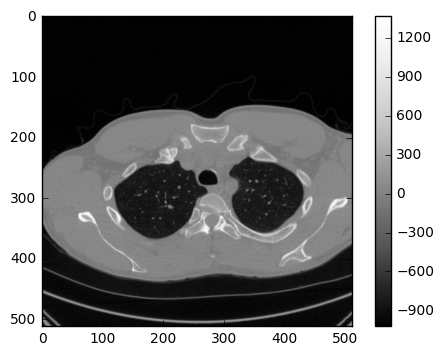

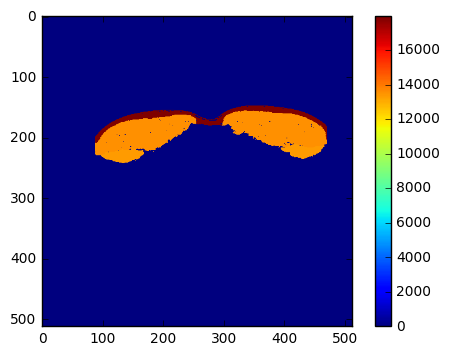

[    0 13335 13336 13591 13592 17943 17944]


In [ ]:
folder = 'ProyectData/'
num_files = [1] # 7 nrrd files in total


# Reading CT

for i in num_files:
    if i == num_files[0]:
        # CTSlices
        file_name_CT = 'Cont_' + str(i+1) + '.nrrd'
        image_nrrd = sitk.ReadImage(folder + file_name_CT)
        CTSlices = sitk.GetArrayFromImage(image_nrrd)
        # Labels
        file_name_label = 'Cont_lm_' + str(i+1) + '.nrrd'
        image_nrrd = sitk.ReadImage(folder + file_name_label)
        labels = sitk.GetArrayFromImage(image_nrrd)
    else:
        # CTSlices
        file_name_CT = 'Cont_' + str(i+1) + '.nrrd'
        image_nrrd = sitk.ReadImage(folder + file_name_CT)
        CTSlices_aux = sitk.GetArrayFromImage(image_nrrd)
        CTSlices = np.concatenate((CTSlices, CTSlices_aux), axis = 0)
        # Labels
        file_name_label = 'Cont_lm_' + str(i+1) + '.nrrd'
        image_nrrd = sitk.ReadImage(folder + file_name_label)
        labels_aux = sitk.GetArrayFromImage(image_nrrd)
        labels = np.concatenate((labels, labels_aux), axis = 0)
        
print('CTSlices Shape: ')
print(CTSlices.shape)

print('Labels Shape: ')
print(labels.shape)

# num_labels = np.unique(labels)

# Image Representation
slice_num = 105
ToraxSlice = CTSlices[slice_num,:,:]
plt.figure()
plt.imshow(ToraxSlice,cmap='Greys_r')
plt.colorbar()
plt.show()

LabelToraxSlice = labels[slice_num,:,:]
plt.figure()
plt.imshow(LabelToraxSlice)
plt.colorbar()
plt.show()
print(np.unique(LabelToraxSlice))

------------------

## Pre-Processing Data

**Normalizing**

In [ ]:
numpy_array = CTSlices.astype(np.float32)
numpy_array[numpy_array < -1024] = -1024
numpy_array[numpy_array > 1500] = 1500
numpy_array = (numpy_array + 1024) / (1500 + 1024) - 0.5

CTSlices_new = numpy_array
print(CTSlices_new.shape)

**Selecting Labels**

Pectorals Labels

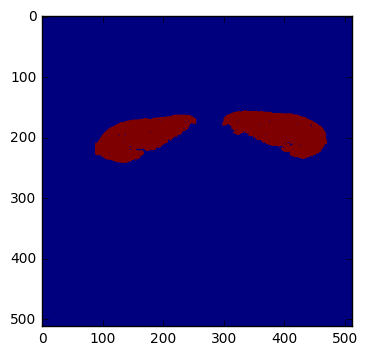

In [28]:
labels[(labels!=13335)&(labels!=13336)&(labels!=13591)&(labels!=13592)] = 0
labels[(labels==13335)] = 1 # Left Minor Pectoral
labels[(labels==13336)] = 1 # Right Minor Pectoral
labels[(labels==13591)] = 1 # Left Major Pectoral
labels[(labels==13592)] = 1 # RIght Major Pectoral
plt.figure()
plt.imshow(labels[slice_num,:,:])
#np.unique(labels[slice_num,:,:])

Fat

In [29]:
#labels[(labels!=17943)&(labels!=17944)] = 0
#labels[(labels==17943)] = 1 # Right Fat (image)
#labels[(labels==17944)] = 1 # Left Fat (image)
#plt.figure()
#plt.imshow(labels[slice_num,:,:])
#np.unique(labels[slice_num,:,:])

-----------------

## Spliting data in Training And Testing

In [30]:
num_images_train = 0
num_images_test = 1500

train_dataset = CTSlices_new[0 : num_images_train,:,:]
train_labels = labels[0 : num_images_train,:,:]
test_dataset = CTSlices_new[num_images_train : num_images_train+num_images_test,:,:]
test_labels = labels[num_images_train : num_images_train+num_images_test,:,:]

print(train_dataset.shape)
print(train_labels.shape)
print(test_dataset.shape)
print(test_labels.shape)

(0, 512, 512)
(0, 512, 512)
(1500, 512, 512)
(1500, 512, 512)


--------------

## U-net Structure

**Loss Functions**

In [8]:
def dice_coef_loss(y_true, y_pred):
    return 1.-dice_coef(y_true, y_pred)

** Accuracy Functions **

In [9]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f*y_true_f) + K.sum(y_pred_f*y_pred_f) + smooth)

In [8]:
def IoU(y_true, y_pred):
    
    y_true = K.round(K.clip(y_true, 0, 1))
    y_pred = K.round(K.clip(y_pred, 0, 1))
    
    tp = K.sum(y_true * y_pred)
    fn = K.sum((y_true + y_pred)*y_true) - tp*2.
    fp = K.sum((y_true + y_pred)*y_pred) - tp*2.

    IoU = (tp)/(tp + fn + fp)
    
    return IoU

**List Of Parameters**

*Loss*

    binary_crossentropy
    categorical_crossentropy*
    mean_squared_error

*Optimizers*

    Adam(lr=, )
    SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)

*Accuracy*

    fbeta_score
    accuracy

#### U-Net Structure

In [9]:
def get_unet():
    
    inputs = Input((512, 512, 1))
    
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    
    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(conv5)
    
    
    up6 = merge([Convolution2D(256, 2, 2,activation='relu', border_mode='same')(UpSampling2D(size=(2, 2))(conv5)), conv4], mode='concat', concat_axis=3)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([Convolution2D(128, 2, 2,activation='relu', border_mode='same')(UpSampling2D(size=(2, 2))(conv6)), conv3], mode='concat', concat_axis=3)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = merge([Convolution2D(64, 2, 2,activation='relu', border_mode='same')(UpSampling2D(size=(2, 2))(conv7)), conv2], mode='concat', concat_axis=3)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([Convolution2D(32, 2, 2,activation='relu', border_mode='same')(UpSampling2D(size=(2, 2))(conv8)), conv1], mode='concat', concat_axis=3)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up9)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv9)

    conv10 = Convolution2D(1, 1, 1, activation='sigmoid')(conv9)

    
    model = Model(input=inputs, output=[conv10])

    model.compile(optimizer=Adam(lr=0.001), loss=binary_crossentropy, metrics=[IoU])
    
    print('U-net Initialized')

    return model

----------

## Train

In [10]:
img_rows = 512
img_cols = 512
smooth = 1.

imgs_train = np.reshape(train_dataset,(num_images_train, img_rows, img_cols, 1))
imgs_mask_train = np.reshape(train_labels,(num_images_train, img_rows, img_cols, 1))


print('Training Shape:', imgs_train.shape)
print('Training Mask Shape:', imgs_mask_train.shape)

('Training Shape:', (400, 512, 512, 1))
('Training Mask Shape:', (400, 512, 512, 1))


In [11]:
model = get_unet()

U-net Initialized


#### Callbacks

In [12]:
model.metrics_names

['loss', 'fbeta_score', 'IoU']

In [12]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.IoU = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.IoU.append(logs.get('IoU'))

In [13]:
# Save model in .hdf5
model_checkpoint = ModelCheckpoint('unet_GPU.hdf5', monitor='loss',verbose=1, save_best_only=True)

# Create a CVS with the values of loss and accuracy at each epoch
model_CVSLogger = CSVLogger('hola.cvs', separator=',', append=True)

# Gets loss values at each batch and epoch in a list
history = LossHistory()

# Early Stopping 
model_EarlyStopping = EarlyStopping(monitor='val_loss', min_delta=0.00005, patience=2, verbose=0, mode='auto')

# Reduce LR
model_ReduceLROnPlateau = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=1, verbose=1, mode='auto', 
                  cooldown=0, min_lr=0.0001) # epsilon=0.0001

# Tensorboard
model_TensorBoard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)

#### Train

In [14]:
batch_size = 10
nb_epoch = 5

training_history = model.fit(imgs_train, imgs_mask_train, batch_size=batch_size, nb_epoch=nb_epoch, 
          verbose=1, shuffle=True, 
          callbacks=[model_checkpoint, history])
          #validation_split=0.2)


InternalError: Dst tensor is not initialized.
	 [[Node: Const_99 = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [128] values: 0 0 0...>, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op u'Const_99', defined at:
  File "/home/rm196/anaconda2/envs/tensorflow/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/rm196/anaconda2/envs/tensorflow/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/rm196/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/rm196/anaconda2/envs/tensorflow/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/rm196/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/rm196/anaconda2/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/rm196/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/rm196/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/rm196/anaconda2/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/rm196/anaconda2/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/rm196/anaconda2/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/rm196/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/rm196/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/rm196/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/rm196/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/rm196/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/rm196/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/rm196/anaconda2/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/rm196/anaconda2/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/rm196/anaconda2/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-32dcfb75b8f6>", line 6, in <module>
    callbacks=[model_checkpoint, history])
  File "/home/rm196/anaconda2/envs/tensorflow/lib/python2.7/site-packages/keras/engine/training.py", line 1097, in fit
    self._make_train_function()
  File "/home/rm196/anaconda2/envs/tensorflow/lib/python2.7/site-packages/keras/engine/training.py", line 714, in _make_train_function
    self.total_loss)
  File "/home/rm196/anaconda2/envs/tensorflow/lib/python2.7/site-packages/keras/optimizers.py", line 394, in get_updates
    vs = [K.zeros(shape) for shape in shapes]
  File "/home/rm196/anaconda2/envs/tensorflow/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py", line 244, in zeros
    return variable(tf.constant_initializer(0., dtype=tf_dtype)(shape), dtype, name)
  File "/home/rm196/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/init_ops.py", line 145, in _initializer
    return constant_op.constant(value, dtype=dtype, shape=shape)
  File "/home/rm196/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/constant_op.py", line 167, in constant
    attrs={"value": tensor_value, "dtype": dtype_value}, name=name).outputs[0]
  File "/home/rm196/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2380, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/rm196/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1298, in __init__
    self._traceback = _extract_stack()

InternalError (see above for traceback): Dst tensor is not initialized.
	 [[Node: Const_99 = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [128] values: 0 0 0...>, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]


In [14]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 512, 512, 1)   0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 512, 512, 32)  320         input_1[0][0]                    
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 512, 512, 32)  9248        convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 256, 256, 32)  0           convolution2d_2[0][0]            
___________________________________________________________________________________________

**Training Results**

*Losses Graphs*

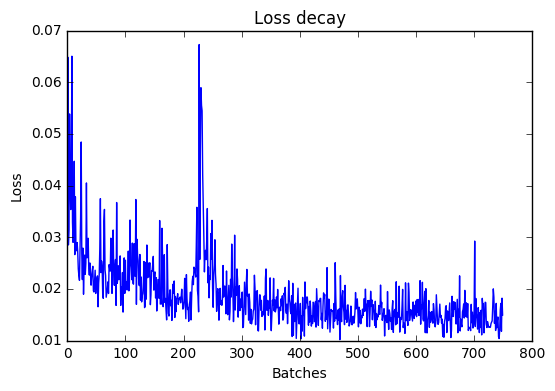

In [35]:
losses = np.array(history.losses)
batches = np.arange(losses.shape[0])

# Plot
plt.plot(batches,losses)
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.title('Loss decay')
plt.show()

*Accuracy*

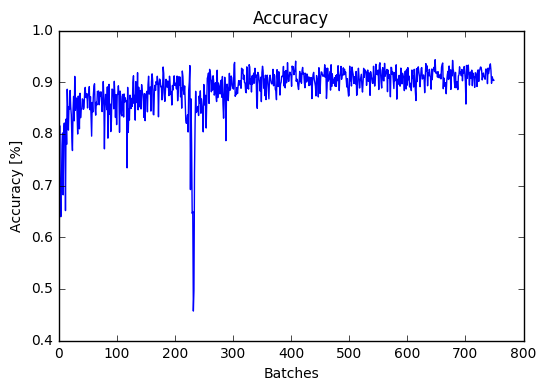

In [36]:
accuracy = np.array(history.accuracy)
batches = np.arange(accuracy.shape[0])

# Plot
plt.plot(batches,accuracy)
plt.xlabel('Batches')
plt.ylabel('Accuracy [%]')
plt.title('Accuracy')
plt.show()

#### Open trained U-net Model

*Saved neural networks:*

    unet_GPU_500im_10ep_001.hdf5
    unet_GPU_500im_40ep_001
    unet_GPU_1400im_8ep_001.hdf5
    unet_GPU_6000im_4ep_lr001.hdf5
    unet_GPU_6000im_9ep_lr001

In [10]:
model = get_unet()
model.load_weights('unet_GPU_6000im_9ep_lr001.hdf5')

U-net Initialized


In [19]:
server.launch(
        model, # a Keras Model

        # where to store temporary files generatedby quiver (e.g. image files of layers)
        temp_folder='./tmp',

        # a folder where input images are stored
        input_folder='./test_images',

        # the localhost port the dashboard is to be served on
        port=5000
    )


Starting webserver from: /home/rm196/anaconda2/envs/tensorflow/lib/python2.7/site-packages/quiver_engine


170.223.221.134 - - [2016-11-21 11:12:45] "GET / HTTP/1.1" 304 214 0.001800
170.223.221.134 - - [2016-11-21 11:12:45] "GET /inputs HTTP/1.1" 200 245 0.001039
170.223.221.134 - - [2016-11-21 11:12:45] "GET /model HTTP/1.1" 200 26087 0.015949
170.223.221.134 - - [2016-11-21 11:13:29] "GET /layer/convolution2d_1/chest_ct_label_0.png HTTP/1.1" 200 1734 1.781804
[2016-11-21 11:13:29,228] ERROR in app: Exception on /predict/chest_ct_label_0.png [GET]
Traceback (most recent call last):
  File "/home/rm196/anaconda2/envs/tensorflow/lib/python2.7/site-packages/flask/app.py", line 1988, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/rm196/anaconda2/envs/tensorflow/lib/python2.7/site-packages/flask/app.py", line 1641, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/rm196/anaconda2/envs/tensorflow/lib/python2.7/site-packages/flask_cors/extension.py", line 161, in wrapped_function
    return cors_after_request(app.make_response(f(*args, **kwargs)

KeyboardInterrupt: 

-----------------

## Test

In [31]:
img_rows = 512
img_cols = 512

#imgs = np.ndarray((num_images_test, img_rows, img_cols, 1), dtype=np.float32)
#imgs_mask = np.ndarray((num_images_test, img_rows, img_cols,1), dtype=np.float32)

#imgs[:,:,:,0] = test_dataset
#imgs_mask[:,:,:,0] = test_labels

imgs_test = np.reshape(test_dataset,(num_images_test, img_rows, img_cols, 1))
imgs_mask_test = np.reshape(test_labels,(num_images_test, img_rows, img_cols, 1))

print('Test Shape: ', imgs_test.shape)
print('Test Mask Shape: ', imgs_mask_test.shape)

('Test Shape: ', (1500, 512, 512, 1))
('Test Mask Shape: ', (1500, 512, 512, 1))


In [32]:
# Test Prediction
print('Test Prediction')
imgs_mask_pred = model.predict(imgs_test, verbose=1) #(imgs_test, verbose=1)

# Test
print('Test Evaluation')
test_evaluation = model.evaluate(imgs_test, imgs_mask_test, verbose=1) #(imgs_test, imgs_mask_test, verbose=1)

# Saving prediction results
np.save('imgs_mask_pred_test.npy', imgs_mask_pred)

print('Test loss:', test_evaluation[0])
print('Test accuracy:', test_evaluation[1])

Test Prediction
1500/1500 [==============================] - 32s    
Test Evaluation
1500/1500 [==============================] - 32s    
('Test loss:', 0.0083088966943323621)
('Test accuracy:', 0.91177933565775549)


----------------

## Results

*Saved Images Results:*

    imgs_mask_pred_train_1400im_8ep_001_test_100_im.npy
    imgs_mask_pred_test_6000im_8ep_lr001.npy

In [18]:
imgs_mask_pred = np.load('imgs_mask_pred_test.npy')

In [20]:
np.unique(imgs_mask_pred)

array([  3.70742971e-19,   3.80612140e-19,   4.26680207e-19, ...,
         3.22673947e-01,   3.45818728e-01,   3.72842401e-01], dtype=float32)

In [17]:
import scipy.misc

#scipy.misc.imsave('pruebaborrar.png', imgs_mask_pred[1,:,:,0])

### Test Results

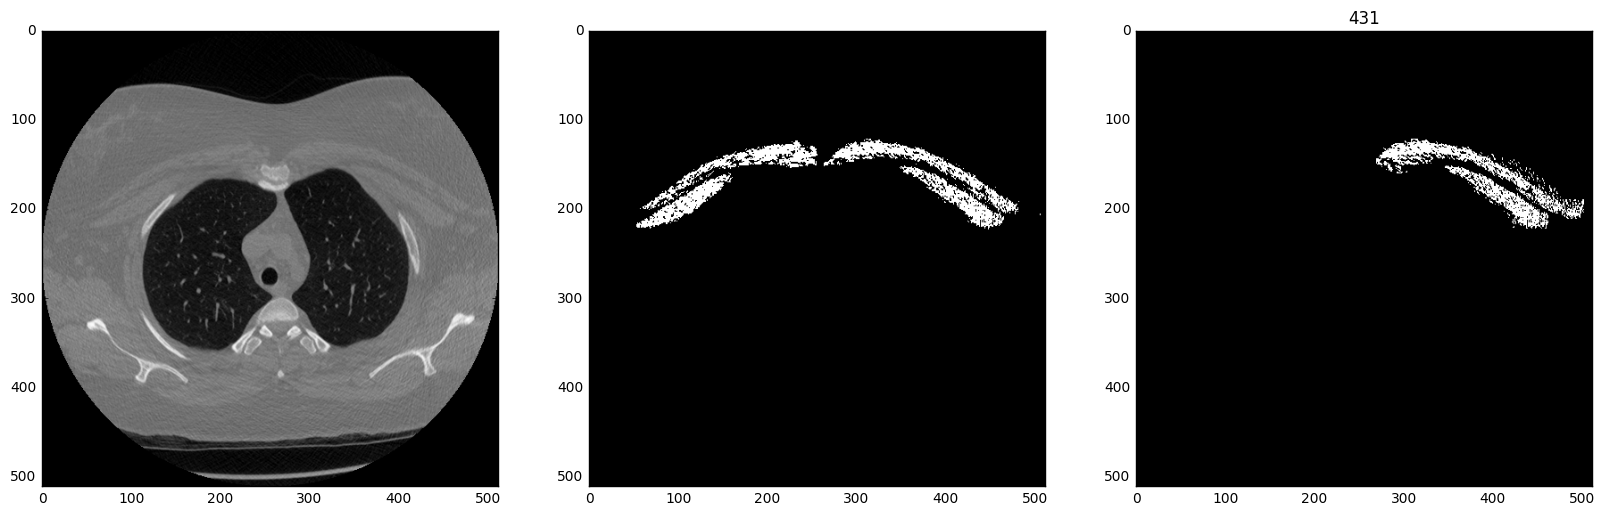

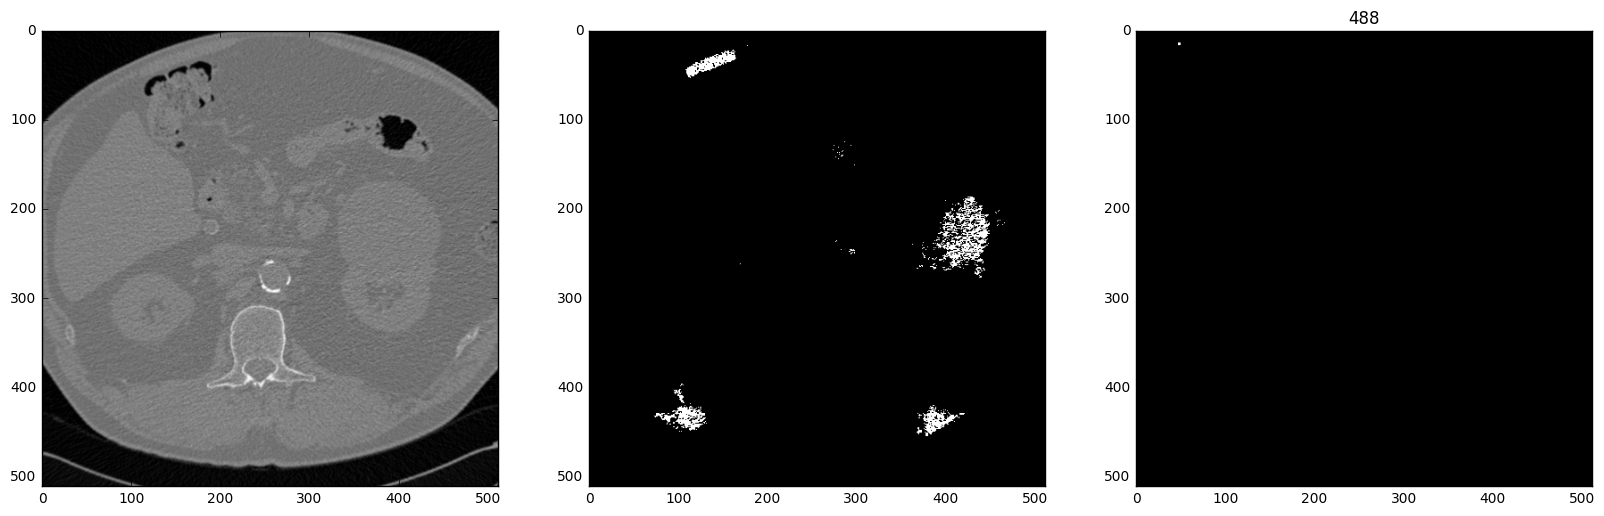

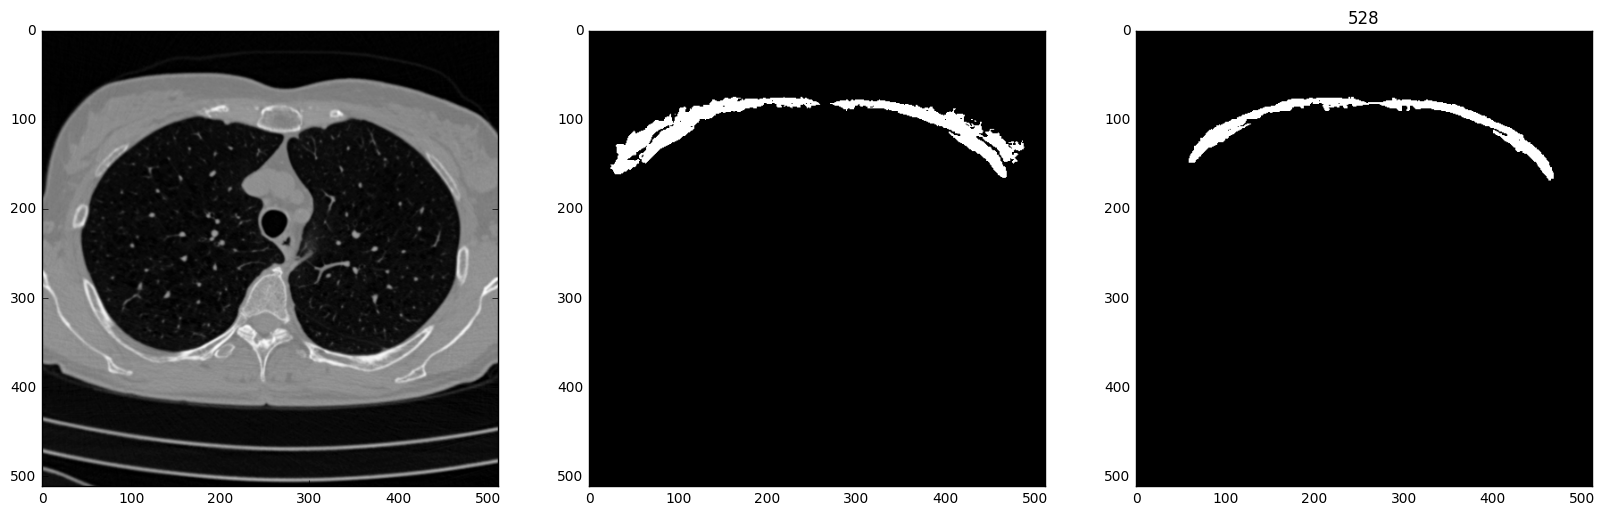

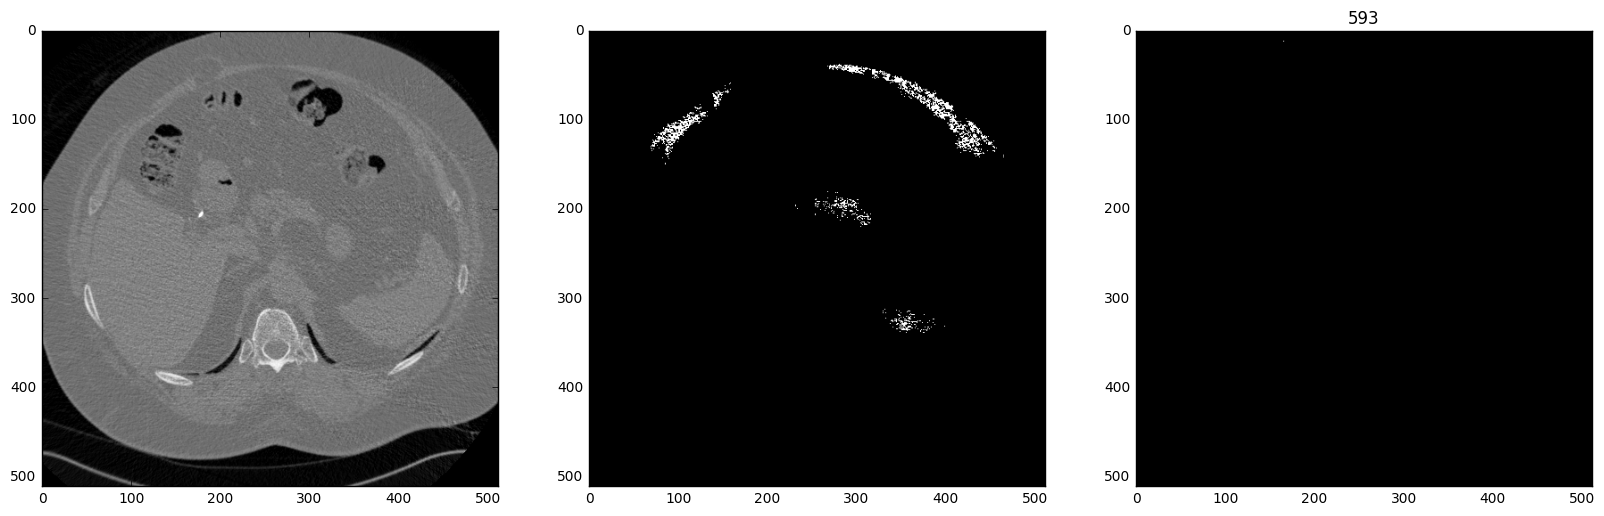

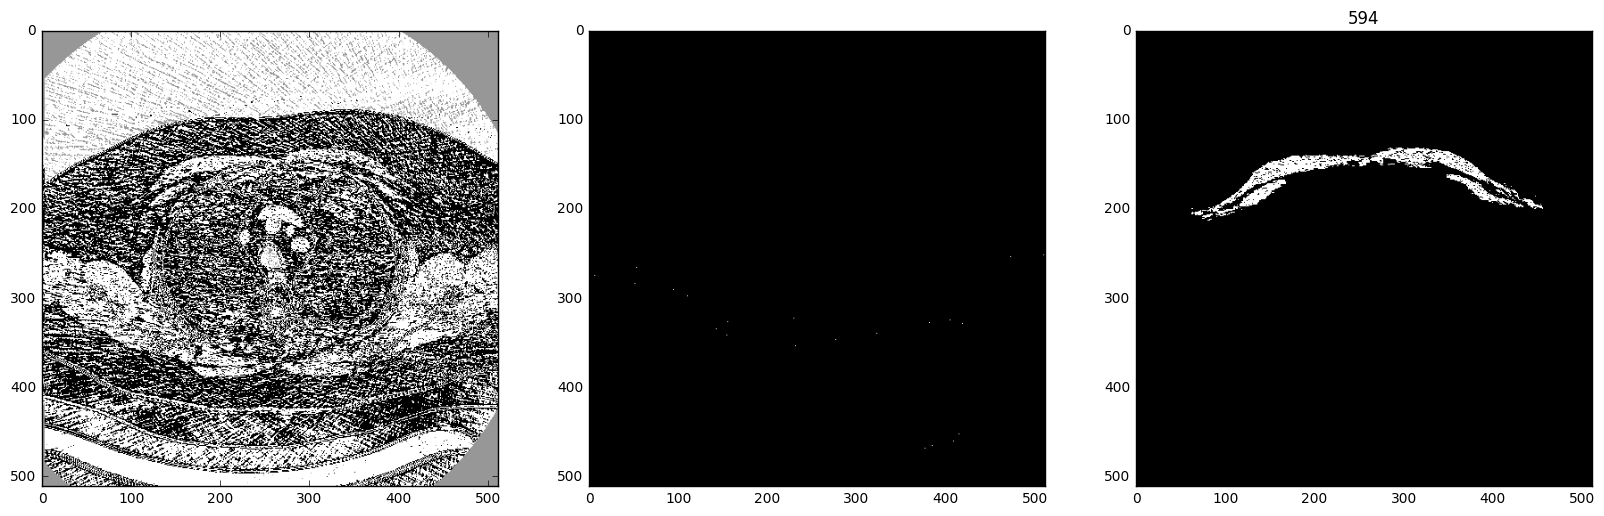

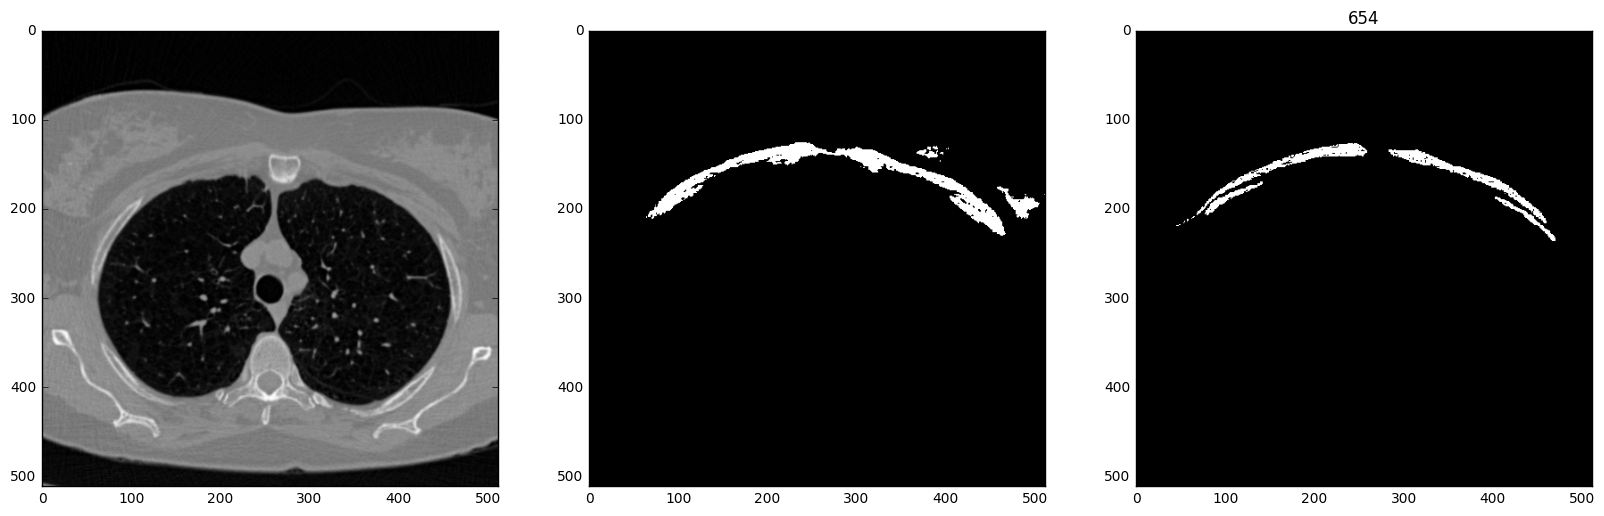

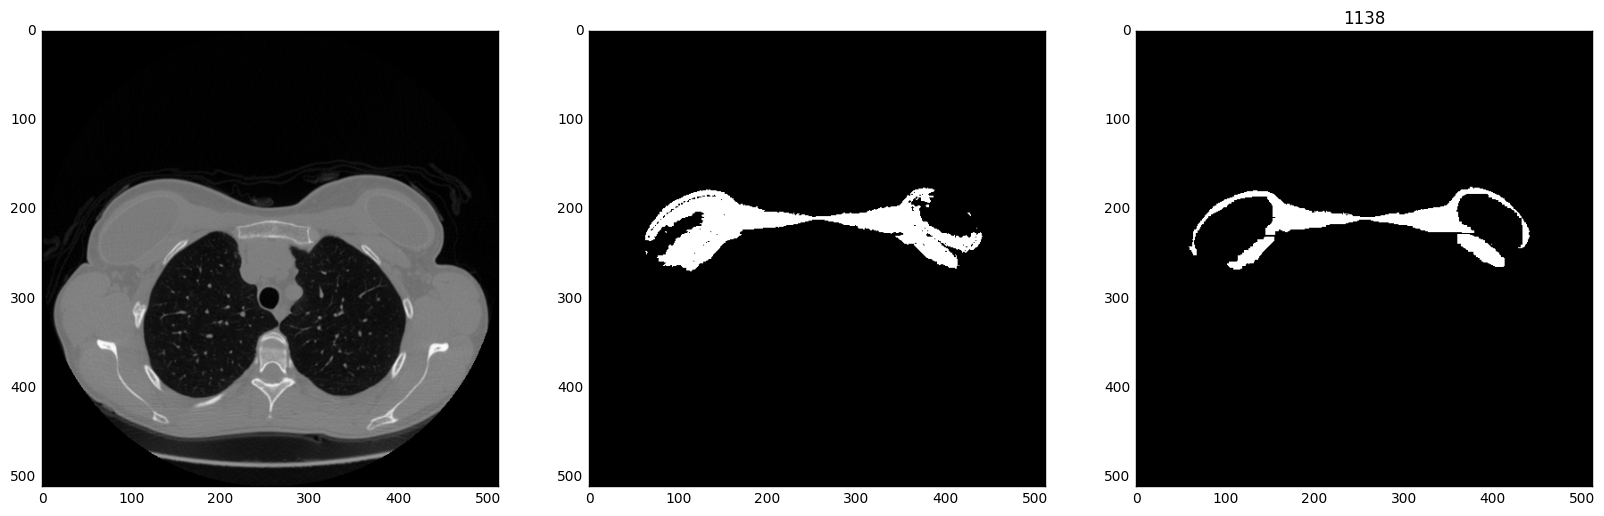

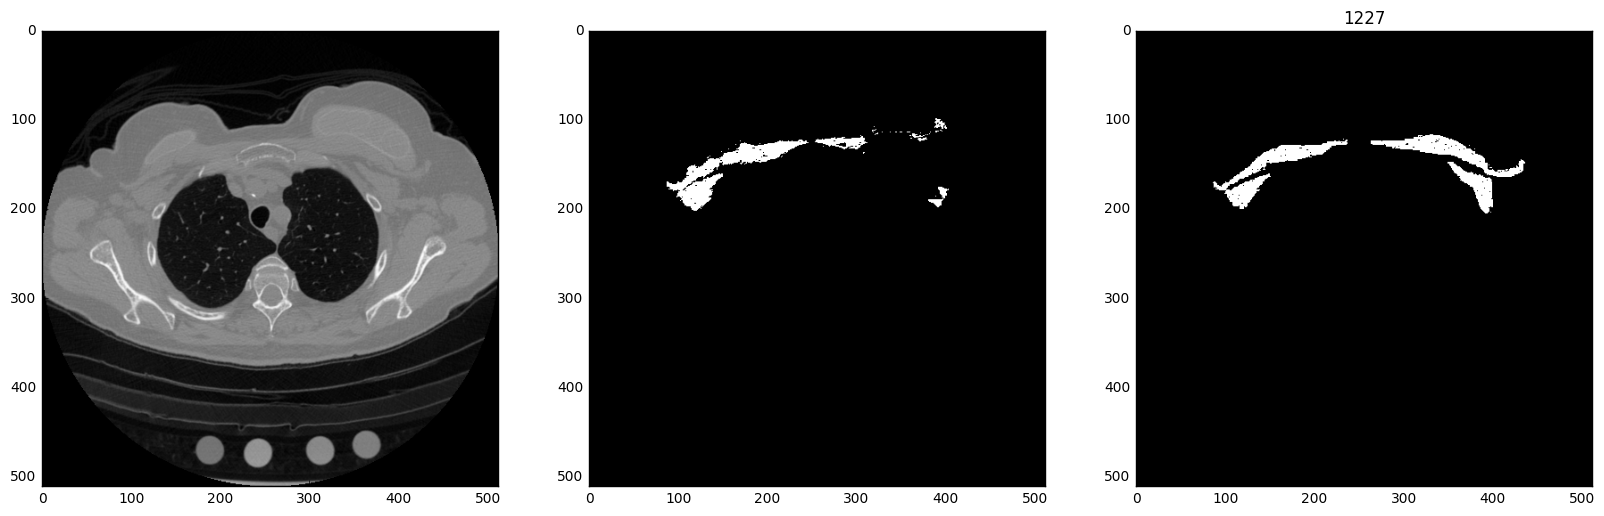

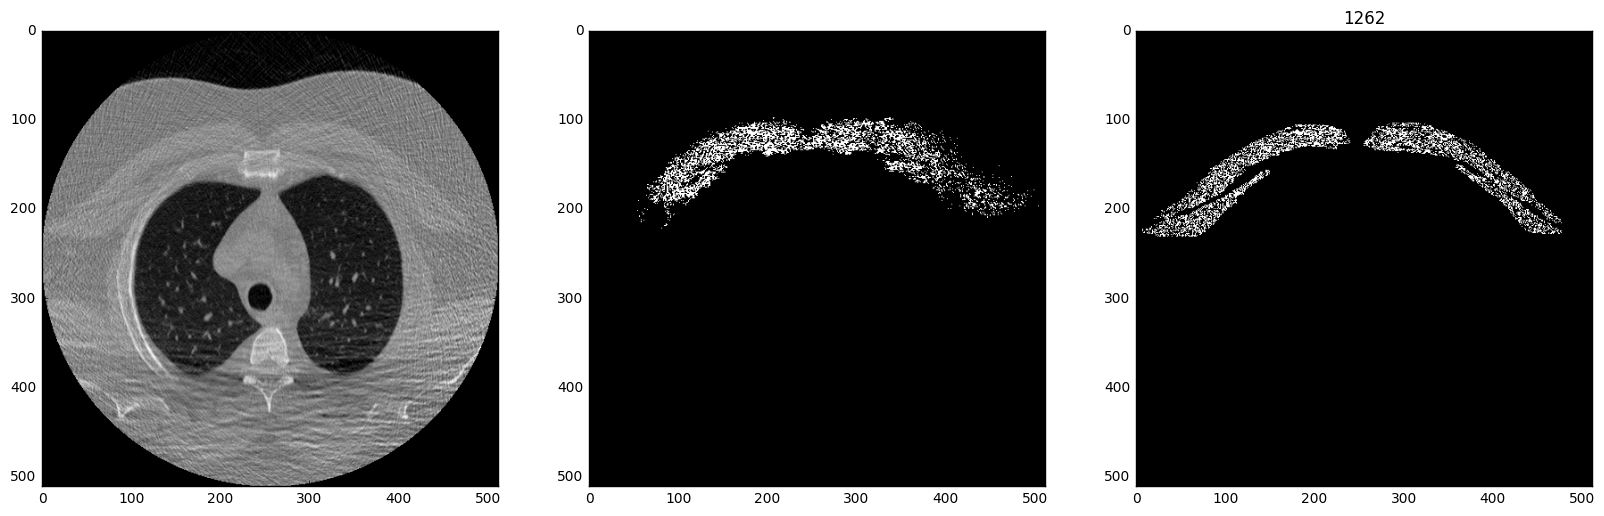

In [35]:
for i in images_bad:
    f, a = plt.subplots(1, 3, figsize=(20, 20))
    a[1].imshow(imgs_mask_pred[i,:,:,0],cmap='Greys_r')
    a[2].imshow(imgs_mask_test[i,:,:,0],cmap='Greys_r')
    a[0].imshow(imgs_test[i,:,:,0],cmap='Greys_r')
    f.show()
    plt.title(str(i))
    plt.draw()
    #plt.savefig('Figures/NN_learning/12ep_subplot_{}.png'.format(i))
    #scipy.misc.imsave('Figures/NN_learning/12ep_mask_pred_{}.png'.format(i),imgs_mask_pred[i,:,:,0])
    #scipy.misc.imsave('Figures/NN_learning/12ep_test_{}.png'.format(i),imgs_mask_test[i,:,:,0])
    #scipy.misc.imsave('Figures/NN_learning/12ep_mask_test{}.png'.format(i),imgs_test[i,:,:,0])

*All Images*

In [17]:
def accuracy_IoU_np(y_true, y_pred):
    tp = np.sum(y_true * y_pred)
    fn = np.sum((y_true + y_pred)*y_true) - tp*2.
    fp = np.sum((y_true + y_pred)*y_pred) - tp*2.

    #beta = 1
    #F_b = ((1+np.power(beta,2))*tp)/((1+np.power(beta,2))*tp + np.power(beta,2)*fn + fp)
    IoU = (tp)/(tp + fn + fp)
    return IoU

In [18]:
th = 0.5
imgs_mask_pred = np.load('imgs_mask_pred_test.npy')
imgs_mask_pred[(imgs_mask_pred>th)] = 1
imgs_mask_pred[(imgs_mask_pred<th)] = 0

acc_test = accuracy_IoU_np(imgs_mask_test,imgs_mask_pred)
print('Test Accuracy', acc_test)

('Test Accuracy', 0.9055044531307328)


In [43]:
imgs_mask_pred = np.load('imgs_mask_pred_test.npy')
acc_test = accuracy_IoU_np(imgs_mask_test,imgs_mask_pred)
print('Test Accuracy', acc_test)

('Test Accuracy', 0.85001062497783197)


*Over Each Image*

In [13]:
def accuracy_IoU_np_individual(y_true, y_pred):
    axis = np.array((1,2))
    tp = np.apply_over_axes(np.sum,(y_true * y_pred), axes=axis)
    fn = np.apply_over_axes(np.sum,((y_true + y_pred)*y_true), axes=axis) - tp*2.
    fp = np.apply_over_axes(np.sum,((y_true + y_pred)*y_pred), axes=axis) - tp*2.

    #beta = 1
    #F_b = ((1+np.power(beta,2))*tp)/((1+np.power(beta,2))*tp + np.power(beta,2)*fn + fp)
    IoU = (tp)/(tp + fn + fp)
    
    return IoU

('Accuracy Mean: ', 0.90699106)


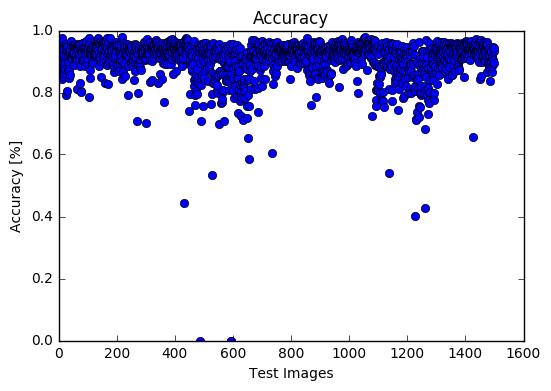

In [33]:
th = 0.5
imgs_mask_pred = np.load('imgs_mask_pred_test.npy')
imgs_mask_pred[(imgs_mask_pred>th)] = 1
imgs_mask_pred[(imgs_mask_pred<th)] = 0

acc_test_image = accuracy_IoU_np_individual(imgs_mask_test,imgs_mask_pred)
print('Accuracy Mean: ', np.mean(acc_test_image[:,0,0,0]))

# Plot 
images = np.arange(num_images_test)

plt.plot(images,acc_test_image[:,0,0,0],'o')
plt.xlabel('Test Images')
plt.ylabel('Accuracy [%]')
plt.title('Accuracy')
plt.show()
#plt.savefig('accuracy_images.png')
plt.draw()

In [34]:
condition = acc_test_image[:,0,0,0]<0.6
images_bad = np.where(condition)[0]
print(images_bad)

[ 431  488  528  593  594  654 1138 1227 1262]


In [22]:
wrong_images = [[900, 983, 1281, 1477],
                [431, 488, 591, 594],
                [996],
                [239],
                [337, 526, 536],
                [1086, 1335],
                [957, 1394]]
wrong_images = np.array(wrong_images)

np.save('Cont_1_wrong_slices.npy',wrong_images)

In [25]:
wrong_images = np.array(images_bad)

np.save('Cont_1_wrong_slices.npy',images_bad)

**Test**

('Threshold with max accuracy: ', 0.45000000000000001)
('Accuracy: ', 0.92951108104855762)


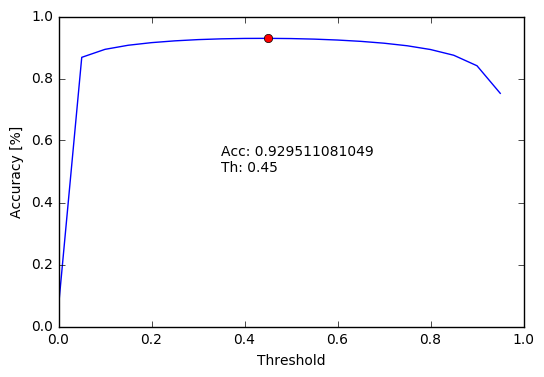

In [69]:
threshold = np.arange(0, 1, 0.05)
acc_test = []

for th in threshold:
    imgs_mask = np.load('imgs_mask_pred_test.npy')
    imgs_mask = imgs_mask[:,:,:,0]
    imgs_mask[(imgs_mask>th)] = 1
    imgs_mask[(imgs_mask<th)] = 0
    acc_test.append(accuracy_IoU_np(imgs_mask_test[:,:,:,0],imgs_mask))
  
acc_test = np.array(acc_test)
#print(acc_test)

# Result
max_index = np.argmax(acc_test)
th_max = threshold[max_index]
acc_max = acc_test[max_index]
print('Threshold with max accuracy: ', th_max)
print('Accuracy: ', acc_max)

# Plot
plt.plot(threshold, acc_test, th_max, acc_max, 'ro')
plt.xlabel('Threshold')
plt.ylabel('Accuracy [%]')
plt.annotate('Acc: '+ str(acc_max) +'\nTh: ' + str(th_max), 
             xy=(th_max, acc_max), xytext=(0.35, 0.5),
            )
# plt.title('Loss decay')
plt.show()


** Training **

In [70]:
# Train Prediction
print('Test Prediction')
imgs_mask_pred_train = model.predict(imgs_train, verbose=1)

# Train Evalutaion
print('Test Evaluation')
train_evaluation = model.evaluate(imgs_train, imgs_mask_train, verbose=1)

# Saving prediction results
np.save('imgs_mask_pred_train.npy', imgs_mask_pred_train)

print('Test loss:', train_evaluation[0])
print('Test accuracy:', train_evaluation[1])

Test Prediction
500/500 [==============================] - 12s    
Test Evaluation
500/500 [==============================] - 12s    
('Test loss:', 0.013121854409575463)
('Test accuracy:', 0.92308719015121465)


In [71]:
th = 0.5
imgs_mask_pred_train = np.load('imgs_mask_pred_train.npy')
imgs_mask_pred_train[(imgs_mask_pred_train>th)] = 1
imgs_mask_pred_train[(imgs_mask_pred_train<th)] = 0

acc_test = accuracy_IoU_np(imgs_mask_train,imgs_mask_pred_train)
print('Test Accuracy', acc_test)

('Test Accuracy', 0.92336573500893071)


('Threshold with max accuracy: ', 0.5)
('Accuracy: ', 0.92336573500893071)


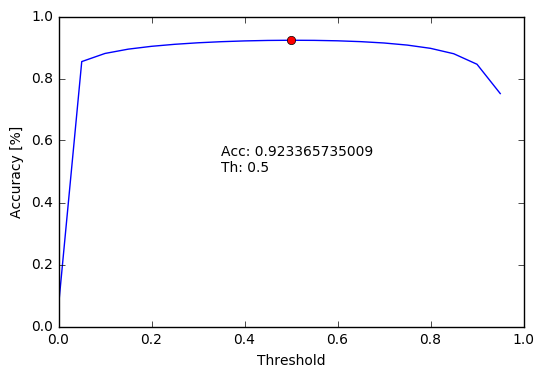

In [72]:
threshold = np.arange(0, 1, 0.05)
acc_test = []

for th in threshold:
    imgs_mask = np.load('imgs_mask_pred_train.npy')
    imgs_mask[(imgs_mask>th)] = 1
    imgs_mask[(imgs_mask<th)] = 0
    acc_test.append(accuracy_IoU_np(imgs_mask_train, imgs_mask))
  
acc_test = np.array(acc_test)
#print(acc_test)

# Result
max_index = np.argmax(acc_test)
th_max = threshold[max_index]
acc_max = acc_test[max_index]
print('Threshold with max accuracy: ', th_max)
print('Accuracy: ', acc_max)

# Plot
# Plot
plt.plot(threshold, acc_test, th_max, acc_max, 'ro')
plt.xlabel('Threshold')
plt.ylabel('Accuracy [%]')
plt.annotate('Acc: '+ str(acc_max) +'\nTh: ' + str(th_max), 
             xy=(th_max, acc_max), xytext=(0.35, 0.5),
            )
# plt.title('Loss decay')
plt.show()